In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,"../")

from src.masked.kernel import VFTSGaussKernel,TSGaussGaussKernel
from src.masked.loss import VarifoldLoss
from src.masked.lddmm import Shooting,Flowing
from src.plotting import plot2Dfigure

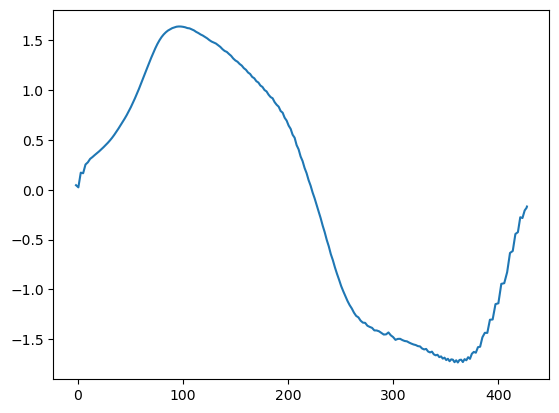

In [2]:
np.random.seed(0)

y =pd.read_csv("./dataset/y.csv",index_col=0)
X = np.load("./dataset/X.npy")
X_mask = np.load("./dataset/X_mask.npy")
idxs = np.load("./results/exp_1_0/idxs.npy")
X,X_mask = X[idxs],X_mask[idxs]
X,X_mask = X[:,::2,:],X_mask[:,::2,:]
y = y.iloc[idxs]



p0s = np.load("./results/exp_1_0/p0s.npy")
q0 = np.load("./results/exp_1_0/q0.npy")
q0_mask = np.load("./results/exp_1_0/q0_mask.npy")
p0s = p0s.reshape(-1,p0s.shape[2],p0s.shape[3])
plt.plot(*q0[q0_mask.squeeze(),:].T)

In [3]:
np.sum(q0_mask)

215

(<Figure size 1000x500 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

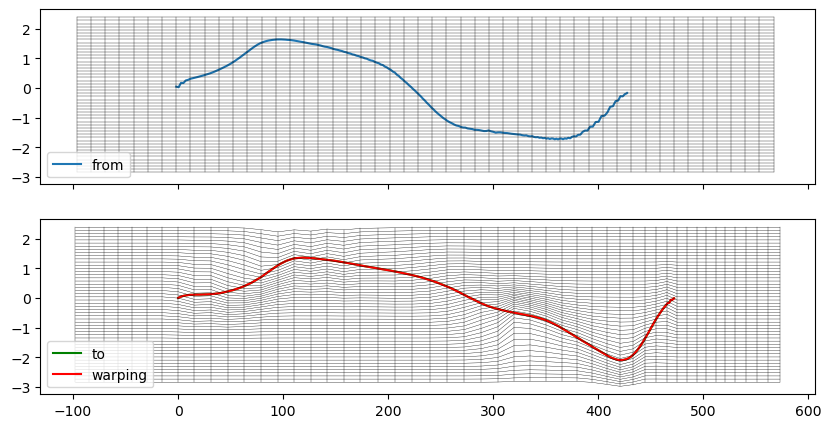

In [4]:
Kv = VFTSGaussKernel(1,0.1,100,1,1)
Kl = TSGaussGaussKernel(2,1,2,0.6)
dataloss = VarifoldLoss(Kl)

shoot = Shooting(Kv)
flow = Flowing(Kv)

plot2Dfigure(q0,X[0],p0s[0],shoot,flow,q0_mask,X_mask[0])

In [5]:
p0s.shape

(700, 1000, 2)

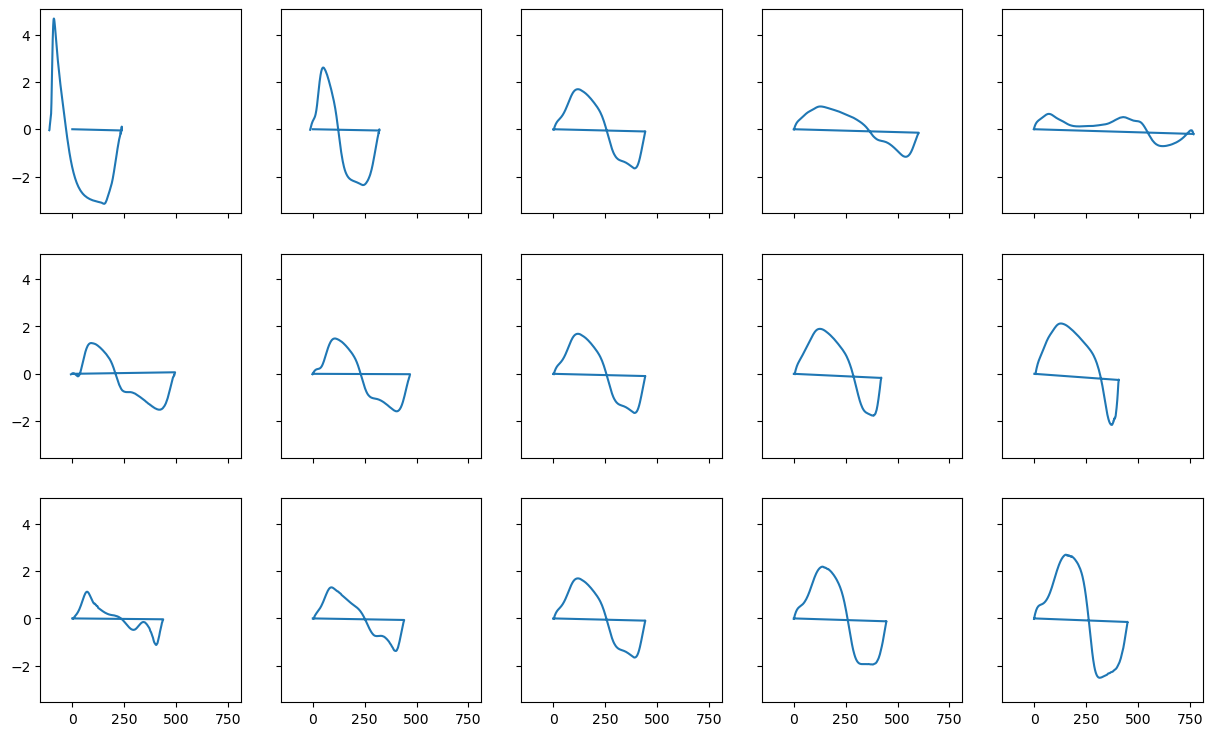

In [6]:
from src.statistic import MomentaPCA
ncomp,ndisp = 3,5
mpca = MomentaPCA(ncomp,masked=True)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*3,ncomp*3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for alpha in np.linspace(-3*sigma_pca , 3*sigma_pca, ndisp):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        plt.subplot(ncomp,ndisp,k)        
        plt.plot(*q.T)
        k += 1
plt.show()

In [7]:
df = y.copy()
filenames = df.filename.unique()

def create_mapping(filenames): 
    dct = {}
    count_colq = 1
    count_wt = 1
    for filename in filenames: 
        if "colq" in filename: 
            dct[filename] = f"colq_{count_colq}"
            count_colq +=1
        elif "wt" in filename: 
            dct[filename] = f"wt_{count_wt}"
            count_wt +=1
    return dct

mapping_dct = create_mapping(filenames)
df["mouse_id"] = df.filename.apply(lambda x :mapping_dct[x])



df[[f"PC{i+1}" for i in range(ncomp)]] = mpca.p_score_
tdf = df[["start","before"]]
max_before = tdf[tdf.before == "Y"].start.max()
tdf.loc[tdf.before == "N","start"] = tdf[tdf.before == "N"].start.copy().values + max_before
tdf.loc[:,"start"] /= (2000.*60.)
df["time"] = tdf.start
df

,filename,genotype,before,start,end,mouse_id,PC1,PC2,PC3,time
3256,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,225591,226064,colq_1,30.324703,-12.032320,-4.651245,1.879925
3408,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2065136,2065561,colq_1,-33.254433,-4.943746,-0.494594,17.209467
3345,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1295651,1296035,colq_1,-73.281273,5.063362,-24.602438,10.797092
3336,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1194516,1194945,colq_1,-23.850719,-7.874161,-11.396433,9.954300
3415,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2139917,2140322,colq_1,-49.356976,1.314148,-16.539072,17.832642
...,...,...,...,...,...,...,...,...,...,...
12306,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,752806,753097,wt_7,-156.544769,65.410263,-16.160854,6.273383
12266,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,298939,299250,wt_7,-171.286972,20.548794,-18.472256,2.491158
12290,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,591395,591757,wt_7,-107.085327,9.243517,-2.277839,4.928292
12427,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,2221605,2221865,wt_7,-192.319489,70.664398,-41.994438,18.513375


In [8]:
import seaborn as sns

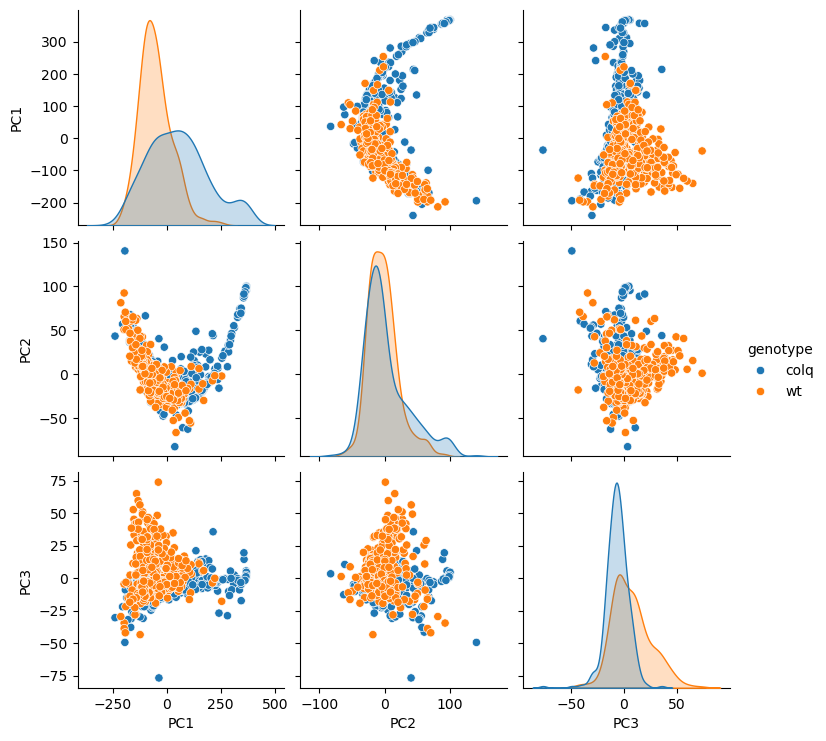

In [9]:
sns.pairplot(df,hue = "genotype",vars=[f"PC{i+1}" for i in range(ncomp)])

In [10]:
tdf = df.copy()
filenames = tdf.filename.unique()

q_lst = []
q_mask_lst = []

for filename in filenames: 
    q = np.load("./results/exp_1_0/"+filename[:-4]+"_q0.npy")
    q_lst.append(q)
    q_mask = np.load("./results/exp_1_0/"+filename[:-4]+"_q0_mask.npy")
    q_mask_lst.append(q_mask)
        
qs = np.array(q_lst)
qs_mask = np.array(q_mask_lst)

In [11]:
qs.shape

(14, 1000, 2)

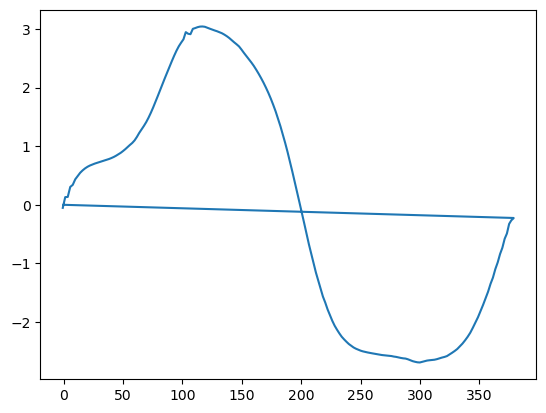

In [12]:
plt.plot(*qs[-3].T)

In [13]:
from src.masked.lddmm import batch_one_to_many_registration
from src.utils import batch_dataset
import optax
from optax.schedules import warmup_cosine_decay_schedule

In [14]:
bqs,bqs_mask = batch_dataset(qs,1,qs_mask)
schedule = warmup_cosine_decay_schedule(0,0.3,40,400,0)
optimizer = optax.adabelief(schedule)
bps,q0,q0_mask = batch_one_to_many_registration(q0,q0_mask,bqs,bqs_mask,Kv,dataloss,optimizer=optimizer,gamma_loss=1e-3,niter=400)

iteration:  1 / 400  -- loss:  1154.21
iteration:  10 / 400  -- loss:  818.09
iteration:  20 / 400  -- loss:  468.89
iteration:  30 / 400  -- loss:  259.06
iteration:  40 / 400  -- loss:  142.67
iteration:  50 / 400  -- loss:  90.73
iteration:  60 / 400  -- loss:  58.80
iteration:  70 / 400  -- loss:  46.10
iteration:  80 / 400  -- loss:  41.19
iteration:  90 / 400  -- loss:  39.07
iteration:  100 / 400  -- loss:  38.72
iteration:  110 / 400  -- loss:  35.18
iteration:  120 / 400  -- loss:  34.07
iteration:  130 / 400  -- loss:  33.27
iteration:  140 / 400  -- loss:  32.09
iteration:  150 / 400  -- loss:  32.22
iteration:  160 / 400  -- loss:  30.56
iteration:  170 / 400  -- loss:  30.10
iteration:  180 / 400  -- loss:  29.83
iteration:  190 / 400  -- loss:  29.31
iteration:  200 / 400  -- loss:  28.97
iteration:  210 / 400  -- loss:  28.93
iteration:  220 / 400  -- loss:  28.51
iteration:  230 / 400  -- loss:  28.36
iteration:  240 / 400  -- loss:  28.17
iteration:  250 / 400  -- loss

In [15]:
pcs =  mpca.transform(bps.squeeze())

In [16]:
lst = []
for i,filename in enumerate(filenames): 
    tlst = [filename,mapping_dct[filename],*pcs[i].tolist()]
    lst.append(tlst)

In [17]:
pdf = pd.DataFrame(lst,columns=["filename","mouse_id",*[f"PC{i+1}" for i in range(ncomp)]])
pdf["genotype"] = pdf["mouse_id"].apply(lambda x : x[:-2])
pdf.dtypes

filename     object
mouse_id     object
PC1         float64
PC2         float64
PC3         float64
genotype     object
dtype: object

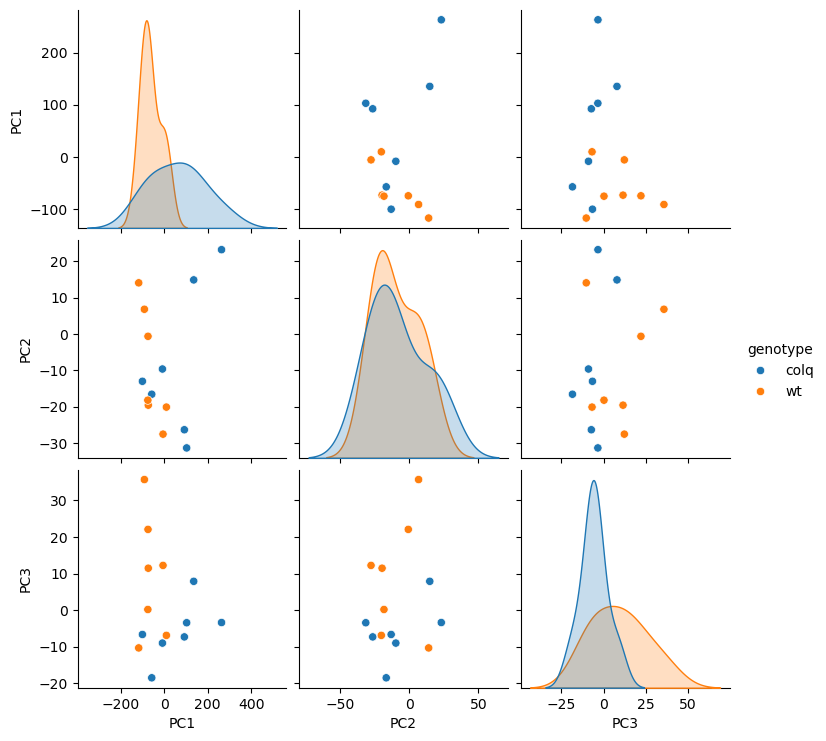

In [18]:
p = sns.pairplot(pdf,hue = "genotype",vars=[f"PC{i+1}" for i in range(ncomp)])
#for line in pdf[["mouse_id",*[f"PC_{i}" for i in range(ncomp)]]].values:
#    for i in range(ncomp): 
#        for j in range(ncomp): 
#            if i != j: 
#                p.axes[i,j].annotate(" "+line[0],(line[j+1],line[i+1]),fontsize=8)


In [19]:
from scipy.stats import gaussian_kde

In [20]:
df

,filename,genotype,before,start,end,mouse_id,PC1,PC2,PC3,time
3256,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,225591,226064,colq_1,30.324703,-12.032320,-4.651245,1.879925
3408,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2065136,2065561,colq_1,-33.254433,-4.943746,-0.494594,17.209467
3345,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1295651,1296035,colq_1,-73.281273,5.063362,-24.602438,10.797092
3336,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,1194516,1194945,colq_1,-23.850719,-7.874161,-11.396433,9.954300
3415,"20160119_colq1#17_physo0,33_i5_e60_ep30.EDF",colq,Y,2139917,2140322,colq_1,-49.356976,1.314148,-16.539072,17.832642
...,...,...,...,...,...,...,...,...,...,...
12306,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,752806,753097,wt_7,-156.544769,65.410263,-16.160854,6.273383
12266,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,298939,299250,wt_7,-171.286972,20.548794,-18.472256,2.491158
12290,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,591395,591757,wt_7,-107.085327,9.243517,-2.277839,4.928292
12427,"20161214_wt#31_physo0,33_i5_e60_ep30.EDF",wt,Y,2221605,2221865,wt_7,-192.319489,70.664398,-41.994438,18.513375


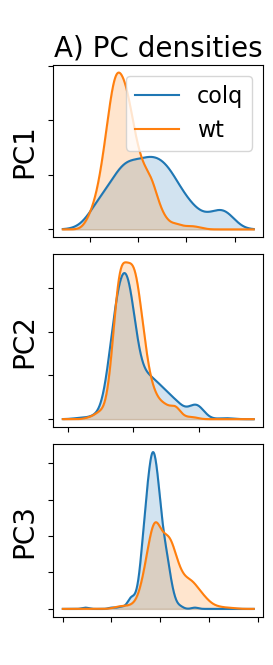

In [21]:
color_mapping ={"colq": "tab:blue", "wt" : "tab:orange"}
components = [f"PC{i+1}" for i in range(ncomp)]
span =0.3
nsample = 10000
ft_size = 20
pft_size = 16



fig,axs = plt.subplots(nrows=ncomp,ncols=1, figsize = (3,ncomp*2.3))
for i,comp in enumerate(components): 
    r = df[comp].values.max()
    l = df[comp].values.min()
    x = np.linspace(l -np.abs(span*l),r +np.abs(span*r),nsample)
    for gen,color in color_mapping.items(): 
        arr = df[df.genotype == gen][comp].values
        y = gaussian_kde(arr)(x)
        axs[i].plot(x,y,color=color,label=gen)
        axs[i].fill_between(x,y,color=color,alpha=0.2)
        axs[i].set_ylabel(comp,fontsize=ft_size)


for ax in axs: 
    ax.set_yticklabels([])
    ax.set_xticklabels([])
axs[0].legend(fontsize=pft_size)
axs[0].set_title("A) PC densities",fontsize=ft_size)
axs[-1].set_xlabel(" ",fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)


plt.subplots_adjust(left=0.2,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.1)
fig.savefig("./exp_1_density.jpeg",format="jpeg")

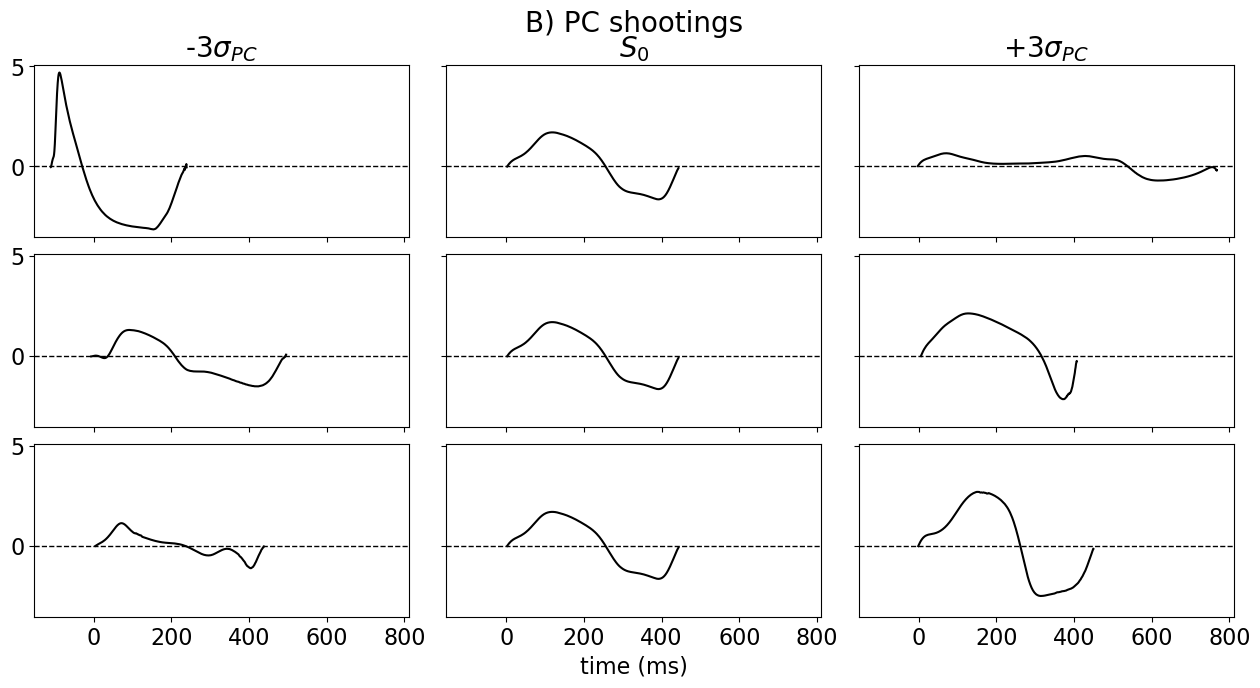

In [22]:
from src.statistic import MomentaPCA
ncomp,ndisp = 3,3
mpca = MomentaPCA(ncomp,masked=True)
mpca.fit(Kv,p0s,q0,q0_mask)

p0_bar = mpca.m_ps_
k = 1

fig,axs = plt.subplots(ncomp,ndisp,figsize = (ndisp*5,ncomp*2.3),sharex=True,sharey=True)
for pca_index in range(ncomp):
    sigma_pca = np.std(mpca.p_score_[:,pca_index])
    for j,alpha in enumerate(np.linspace(-3*sigma_pca , 3*sigma_pca, ndisp)):
        p0_mode = p0_bar + alpha * mpca.p_pc_[pca_index]
        p,q = shoot(p0_mode,q0,q0_mask)
        axs[pca_index,j].plot(*q[q0_mask.squeeze()].T,color="black")
        k += 1

for ax in axs.flatten():
    ax.axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[-1,1].set_xlabel("time (ms)",fontsize=pft_size)

axs[0,0].set_title(r"-3$\sigma_{PC}$",fontsize=ft_size)
axs[0,1].set_title(r"$S_0$",fontsize=ft_size)
axs[0,2].set_title(r"+3$\sigma_{PC}$",fontsize=ft_size)
for ax in axs[-1,:]:
    ax.xaxis.set_tick_params(labelsize=pft_size)
for ax in axs[:,0]:
    ax.yaxis.set_tick_params(labelsize=pft_size)

fig.suptitle("B) PC shootings",fontsize = ft_size)

plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.1)
fig.savefig("./exp_1_shooting.jpeg",format="jpeg")


In [23]:
idxs = np.argsort(pdf.PC1.values)[::-1]

In [24]:
idxs

array([ 5,  4,  6,  3,  8,  9,  1,  0,  7, 10, 12, 11,  2, 13])

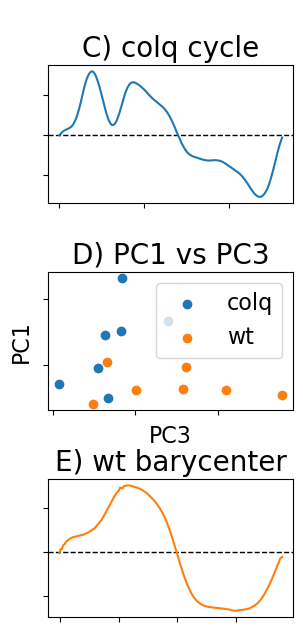

In [25]:
fig,axs = plt.subplots(nrows=ncomp,ncols=1, figsize = (3.5,ncomp*2.3))

idxs = np.argsort(df.PC1.values)[::-1]
idx = idxs[154]
q = X[idx]
q_mask = X_mask[idx]
axs[0].set_title("C) colq cycle",fontsize =ft_size)
axs[0].plot(*q[q_mask.squeeze()].T,color = color_mapping["colq"])
axs[0].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

axs[1].set_title("D) PC1 vs PC3",fontsize =ft_size)
c = pdf[pdf.genotype == "colq"][["PC3","PC1"]].values
axs[1].scatter(*c.T,color=color_mapping["colq"],label="colq")
w = pdf[pdf.genotype == "wt"][["PC3","PC1"]].values
axs[1].scatter(*w.T,color = color_mapping["wt"],label="wt")
axs[1].set_xlabel("PC3", fontsize=pft_size)
axs[1].set_ylabel("PC1", fontsize=pft_size)

axs[2].set_title("E) wt barycenter",fontsize =ft_size)
idx = pdf.PC3.argmax()
axs[2].plot(*qs[idx][qs_mask[idx].squeeze()].T,color= color_mapping["wt"])
axs[2].axhline(0,color="black",linewidth=1,linestyle="--",zorder=0)

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])

axs[1].legend(fontsize=pft_size)
fig.suptitle(" ",fontsize=ft_size)
plt.subplots_adjust(left=0.2,bottom=0.1,right=0.9,top=0.9,wspace=0.1,hspace=0.5)

fig.savefig("./exp_1_exemple.jpeg",format="jpeg")
